Index(['query_category', 'query_thread', 'query_text', 'query_annotations',
       'typ_dsyn', 'typ_patf', 'typ_sosy', 'typ_dora', 'typ_fndg', 'typ_menp',
       'typ_chem', 'typ_orch', 'typ_horm', 'typ_phsu', 'typ_medd', 'typ_bhvr',
       'typ_diap', 'typ_bacs', 'typ_enzy', 'typ_inpo', 'typ_elii',
       'document_category', 'document_thread', 'document_text',
       'document_is_doctor_reply', 'document_number_votes_h',
       'document_number_votes_s', 'document_number_votes_t',
       'document_user_status', 'document_annotations', 'd_typ_dsyn',
       'd_typ_patf', 'd_typ_sosy', 'd_typ_dora', 'd_typ_fndg', 'd_typ_menp',
       'd_typ_chem', 'd_typ_orch', 'd_typ_horm', 'd_typ_phsu', 'd_typ_medd',
       'd_typ_bhvr', 'd_typ_diap', 'd_typ_bacs', 'd_typ_enzy', 'd_typ_inpo',
       'd_typ_elii', 'relationships_list', 'bm25_relevant', 'bm25_score',
       'predicted_prob'],
      dtype='object')
Hello there docker!


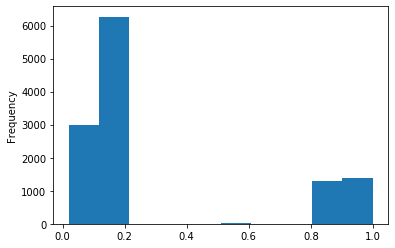

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, average_precision_score


df_valid = pd.read_csv("d:/downloads/json/ehealthforum/trac/validation_df2.txt", sep="\t", header=0)
df_valid = df_valid.drop('Unnamed: 0', axis=1)
print(df_valid.columns)

df_valid['predicted_prob'].plot.hist(bins=10)
plt.savefig("d:/downloads/json/ehealthforum/trac/plot.png")


print("Hello there docker!")

METRIC_AT = 5
PROBABILITY_CUTOFF = 0.1


def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])
#
#
def classify_my_probs(x, cutoff):
    return 1 if x > cutoff else 0

def compute_precision_at_k(l, k):
    l = l[:k]
    return sum(l)/k



In [7]:
# for cutoff in range(1, 10):

# PROBABILITY_CUTOFF = (cutoff / 10)
PROBABILITY_CUTOFF = 0.5

df_valid['predicted_label'] = df_valid['predicted_prob'] >= PROBABILITY_CUTOFF

mapk_true = (df_valid.sort_values(['query_thread', 'bm25_score'], ascending=[True, False])
             .groupby('query_thread')
             .head(10)
             .groupby('query_thread')['document_text']
             .apply(list)
             .tolist())

mapk_predicted = (df_valid.sort_values(['query_thread', 'predicted_prob'], ascending=[True, False])
                  .groupby('query_thread')
                  .head(10)
                  .groupby('query_thread')['document_text']
                  .apply(list)
                  .tolist())

print("\nCutoff value (labelled True if above): " + str(PROBABILITY_CUTOFF) + '\nMetrics@: ' + str(METRIC_AT) + '\n')

# print(average_precision_score(Y_valid, np.transpose(valid_probabilities)[1]))


Cutoff value (labelled True if above): 0.5
Metrics@: 5



In [8]:
print("Number of True relevant: " + str(df_valid[df_valid.bm25_relevant == 1].count()['bm25_relevant']))
print("Number of Predicted relevant: " + str(
    df_valid[df_valid.predicted_label == 1].count()['predicted_label']) + '\n')

df_tru = df_valid.groupby(['query_thread']).head(10)['bm25_relevant']
# df_tru = df_valid.groupby(['query_thread']).head(10)

df_pred = df_valid.groupby(['query_thread']).head(10)['predicted_label']



Number of True relevant: 5990
Number of Predicted relevant: 2713



In [9]:
overall_precision = []

for query, group in df_valid.groupby(['query_thread']):
    precision = compute_precision_at_k(group['predicted_label'].head(10).tolist(), 10)
    overall_precision.append(precision)
    
    
print('Overall precision: ' + str(sum(overall_precision)/len(overall_precision)))
print("Accuracy: " + str(accuracy_score(df_tru, df_pred)))
# print("Precision: " + str(compute_precision_at_k(df_pred, 10)))
print("MAP@"+str(METRIC_AT) + ': ' + str(mapk(mapk_true, mapk_predicted, METRIC_AT)))



Overall precision: 0.3053422370617696
Accuracy: 0.3053422370617696
MAP@5: 0.6556649972175849


In [11]:
def calculate_overlap_coef(x):
    document_annotations = set(x['document_annotations'])
    query_annotations = set(x['query_annotations'])

    smaller = document_annotations if len(document_annotations) < len(query_annotations) else query_annotations

    if len(smaller) == 0:
        return 0
    else:
        return len(document_annotations.intersection(query_annotations)) / len(smaller)




def get_lenghth(x):
    return len(x)

df_valid['doc_length'] = df_valid['document_text'].apply(get_lenghth)
df_valid['entity_overlap_coef'] = df_valid[['document_annotations', 'query_annotations']].apply(calculate_overlap_coef)

plt.hist(df_valid['entity_overlap_coef'], bins=8)

# df_valid['']



KeyboardInterrupt: 